# Exploring multi-agent RL environment and understanding the differences from single-agent RL

In [2]:
from pettingzoo.classic import rps_v2
import os
import matplotlib.pyplot as plt
import gymnasium.spaces as spaces
from ray.rllib.env.multi_agent_env import MultiAgentEnv
import numpy as np

os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

## Rock, paper, scissor game from PettingZoo library

Unlike single-agent environments which have a well-defined standard library ([Gymnasium](https://gymnasium.farama.org/index.html)), the multi-agent environments have different APIs which usually depends on the library being analyzed. Here, in this notebook, we are going to analyze the [PettingZoo](https://pettingzoo.farama.org/index.html) library environment for rock, paper and scissor environment.

In a rock, paper, scissor game, there are two people competing against each other. Therefore, instead of a single action in each round, there two actions and two observations (one for each agent). So, let's try to understand how the PettingZoo environment implement it.

In [3]:
env = rps_v2.parallel_env(render_mode="rgb_array")

Let's observe the action space definition to the rock, paper, and scissor environment.

In [4]:
env.action_spaces

/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/pettingzoo/utils/conversions.py:158: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(


{'player_0': Discrete(3), 'player_1': Discrete(3)}

In the action space above, there are two Discrete spaces utilizing Gymnasium spaces. Those are the same spaces we utilized before in [lesson 1 nb 1](../lesson_1/1-gymnasium_environment.ipynb) for a single agent. Here they are combined in a Python dictionary, but we could also use a composite provided by [Gymnasium](https://gymnasium.farama.org/api/spaces/composite/). Therefore, in an environment with 2 agents, there are two keys representing each of them with their respective spaces.

In case the composite space from Gymnasium were utilized, we could use action_spaces.sample() to provide samples of the action space considering the defined structure and characteristics. Let's provide a quick example:

In [5]:
example_action_space = spaces.Dict(
    {"player_0": spaces.Discrete(3), "player_1": spaces.Discrete(3)}
)
print(example_action_space.sample())

OrderedDict([('player_0', np.int64(1)), ('player_1', np.int64(1))])


When generating samples the dictionary contains both the player_0 and player_1 samples.

A similar behavior could be visualized in the observation space.

In [6]:
env.observation_spaces

/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/pettingzoo/utils/conversions.py:144: UserWarning: The `observation_spaces` dictionary is deprecated. Use the `observation_space` function instead.
  warnings.warn(


{'player_0': Discrete(4), 'player_1': Discrete(4)}

The observation is the last opponent action and its space is a scalar value with 4 possible values. Since both players reveal their choices at the same time, the observation is None until both players have acted. Therefore, 3 represents no action taken yet. Rock is represented with 0, paper with 1 and scissors with 2.

**Each agent receives a reward 0 when the rounds ends in a draw, +1 if the agent win and -1 if the agent loses. An episode is finished when one of the agents win.**

### Running the environment with random agents

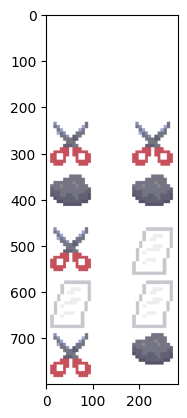

In [7]:
observations, infos = env.reset()

while env.agents:
    # this is where you would insert your policy
    actions = example_action_space.sample()

    observations, rewards, terminations, truncations, infos = env.step(actions)
    # Code to show the animation
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()
    # End - Code to show the animation
env.close()

As mentioned before, the reward values are:

In [8]:
print(rewards)

defaultdict(<class 'int'>, {'player_0': 0, 'player_1': 0})


where there is one reward value for each agent.

## Creating a custom environment using the Ray RLlib API

Let's create a 2D scenario with two robots(agents) where each robot is located in the top and bottom corners position of the environment. The agents can move in the 4 directions (up, down, right, left) and they need to find each other by moving to the same box. The observation space is represented as the number of boxes of distance between the two robots. The reward is -1 for every step the robots did not find each other, so they are incentivized to find each other in less steps, so it can maximize the cumulative reward (return).

In [17]:
class RobotsMeeting(
    MultiAgentEnv
):  # We have to inherit from MultiAgentEnv from Ray RLlib similarly to Gymnasium API
    def __init__(
        self,
        scenario_size: int = 10,
        render: bool = False,
    ):
        self.scenario_size = scenario_size  # scenario_size x scenario_size grid
        self.scenario = np.zeros((self.scenario_size, self.scenario_size))
        self.action_space = spaces.Dict(
            {
                "robot_1": spaces.Discrete(4),  # 0: up, 1: down, 2: left, 3: right
                "robot_2": spaces.Discrete(4),
            }
        )
        self.observation_space = spaces.Dict(
            {
                "robot_1": spaces.Discrete(
                    self.scenario_size * 2 - 2
                ),  # The maximum distance between two points in a grid is 2 * scenario_size - 2
                "robot_2": spaces.Discrete(self.scenario_size * 2 - 2),
            }
        )
        self.robots = {
            "robot_1": {
                "number": 1,
                "pos": [0, 0],
            },
            "robot_2": {
                "number": 2,
                "pos": [self.scenario_size - 1, self.scenario_size - 1],
            },
        }
        self.scenario[0, 0] = self.robots["robot_1"]["number"]
        self.scenario[self.scenario_size - 1, self.scenario_size - 1] = self.robots[
            "robot_2"
        ]["number"]
        if render:
            plt.figure()
            plt.show()
            self.render()

    def reset(self):
        # Reseting scenario and returning robots to initial positions
        self.scenario = np.zeros((self.scenario_size, self.scenario_size))
        self.scenario[0, 0] = self.robots["robot_1"]["number"]
        self.scenario[self.scenario_size - 1, self.scenario_size - 1] = self.robots[
            "robot_2"
        ]["number"]
        obs = {
            "robot_1": self.scenario_size * 2 - 2,
            "robot_2": self.scenario_size * 2 - 2,
        }
        info = {}
        return (obs, info)

    def step(self, action_dict):
        for agent, action in action_dict.items():
            if action == 0:  # Up
                if self.robots[agent]["pos"][0] == 0:
                    continue
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1]
                ] = 0
                self.scenario[
                    self.robots[agent]["pos"][0] - 1, self.robots[agent]["pos"][1]
                ] = self.robots[agent]["number"]
                self.robots[agent]["pos"][0] -= 1
            elif action == 1:  # Down
                if self.robots[agent]["pos"][0] == self.scenario_size - 1:
                    continue
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1]
                ] = 0
                self.scenario[
                    self.robots[agent]["pos"][0] + 1, self.robots[agent]["pos"][1]
                ] = self.robots[agent]["number"]
                self.robots[agent]["pos"][0] += 1
            elif action == 2:  # Left
                if self.robots[agent]["pos"][1] == 0:
                    continue
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1]
                ] = 0
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1] - 1
                ] = self.robots[agent]["number"]
                self.robots[agent]["pos"][1] -= 1
            elif action == 3:  # Right
                if self.robots[agent]["pos"][1] == self.scenario_size - 1:
                    continue
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1]
                ] = 0
                self.scenario[
                    self.robots[agent]["pos"][0], self.robots[agent]["pos"][1] + 1
                ] = self.robots[agent]["number"]
                self.robots[agent]["pos"][1] += 1
            else:
                raise ValueError("Invalid action")

        distance = np.abs(  # Calculate the distance between two robots
            self.robots["robot_1"]["pos"][0] - self.robots["robot_2"]["pos"][0]
        ) + np.abs(self.robots["robot_1"]["pos"][1] - self.robots["robot_2"]["pos"][1])
        obs = {
            "robot_1": distance,
            "robot_2": distance,
        }
        reward_value = (
            0 if np.isclose(distance, 0) else -1
        )  # Reward is 0 if the robots meet, -1 otherwise
        done = (
            True if reward_value == 0 else False
        )  # Terminate the episode if the robots meet
        reward = {"robot_1": reward_value, "robot_2": reward_value}
        terminated = {"player_1": done, "player_2": done}
        truncated = {"player_1": done, "player_2": done}
        terminated["__all__"], truncated["__all__"] = done, done
        info = {}
        return (obs, reward, terminated, truncated, info)

    def render(self):
        clear_output(wait=True)
        plt.imshow(self.scenario)
        plt.show()

    def close(self):
        plt.close()

### Running the environment with random agents

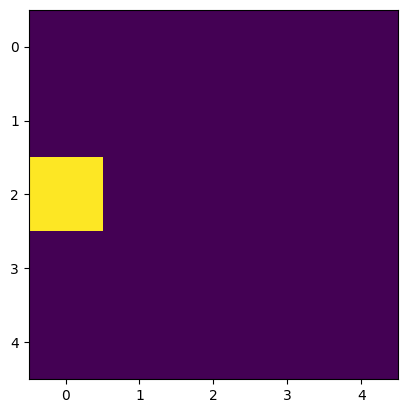

Number of steps: 69


In [30]:
env = RobotsMeeting(scenario_size=5, render=True)
continue_episode = True
number_steps = 0
while continue_episode:
    actions = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(actions)
    number_steps += 1
    env.render()
    if terminated["__all__"]:
        continue_episode = False
env.close()

print("Number of steps:", number_steps)